IOError: [Errno 2] No such file or directory: 'C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/BikeTeam.png'

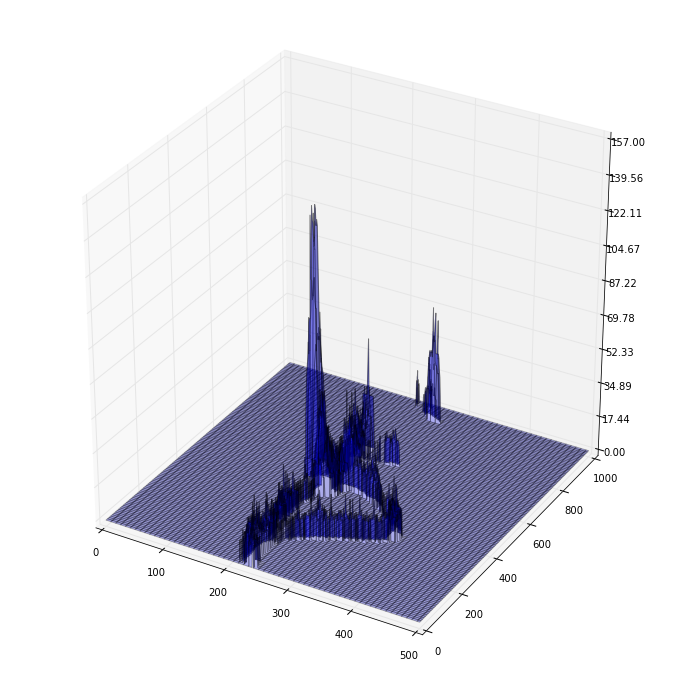

In [2]:
import csv
import sys
import numpy as np
import pandas as pd
from scipy import stats, integrate
#import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib._png import read_png
from matplotlib.cbook import get_sample_data
from scipy import misc

import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

%matplotlib inline

#sns.set(color_codes=True)


width = 12
height = 12

array_x=[]
array_y=[]
array_time=[]

array_x_org=[]
array_y_org=[]

ProbMatrix = np.zeros((501, 1001), dtype=np.int)

imageName= ' BikeTeam' # It needs a space in front
savedImageName= 'BikeTeam'
#person= 'Ana'
#persons_array=["Cagri", "Martin", "Ana"]
persons_array=["Ana"]

for person in persons_array :

    array_x=[]
    array_y=[]
    array_time=[]

    array_x_org=[]
    array_y_org=[]

    #***********************************************************************
    # Read the csv file and store in arrays (x,y) values
    #***********************************************************************

    #f = open('stats_Ana_5Images_15min.csv', 'rt')
    
    f = open(('stats_' + person + '.csv'), 'rt')
   
    try:
        reader = csv.reader(f)
        for row in reader:
 
            if row != []:
                if row[1] == imageName:
                
                    array_x_org.append(np.around(float(row[3]), decimals=2)) 
                    array_y_org.append(np.around(float(row[4]), decimals=2)) 
                
                    array_x.append(int((np.around(float(row[3]), decimals=2)*100) + 500)) # Depends on the size of the equirectangular image
                    array_y.append(int((np.around(float(row[4]), decimals=2)*100) + 250)) 
                
                    array_time.append(np.around(float(row[2]))) 

    finally:
        f.close()

    
    
    
    array_x = np.array(array_x)  
    array_y = np.array(array_y)
    array_time = np.array(array_time)

    max_time =  np.max(array_time, axis=0)
    min_time =  np.min(array_time, axis=0)


    #*********************************************************************************
    # Assigns +1 in a position (x,y) detected, also points around (10 x 10 pixels)
    #*********************************************************************************

    for i in range(len(array_x)):
        x = array_x[i]
        y = array_y[i]
        ProbMatrix[y, x] += 1
    
        for j in range(10): # Location of the gaze is surrounded by 10 x 10 pixels in the reduced resolution of the image
            x1 = x + j
            x2 = x - j
            y1 = y + j
            y2 = y - j
        
            if x1 < 500:
                ProbMatrix[y, x1] += 1

            if x2 > 0:
                ProbMatrix[y, x2] += 1
        
            if y1 < 1000:
                ProbMatrix[y1, x] += 1
            
            if y2 > 0:
                ProbMatrix[y2, x] += 1
                
            for k in range(10):
                x3 = x + k
                x4 = x - k
                y3 = y + k
                y4 = y - k
                
                # Fix y1, y2
                if x3 < 500 and y1 < 1000:
                    ProbMatrix[y1, x3] += 1
        
                if x3 < 500 and y2 > 0:
                    ProbMatrix[y2, x3] += 1
            
                if x4 > 0 and y1 < 1000:
                    ProbMatrix[y1, x4] += 1
            
                if x4 > 0 and y2 > 0:
                    ProbMatrix[y2, x4] += 1
                
                # Fix x1, x2
                if x1 < 500 and y1 < 1000:
                    ProbMatrix[y1, x3] += 1
        
                if x1 < 500 and y2 > 0:
                    ProbMatrix[y2, x3] += 1
            
                if x2 > 0 and y1 < 1000:
                    ProbMatrix[y1, x4] += 1
            
                if x2 > 0 and y2 > 0:
                    ProbMatrix[y2, x4] += 1 
            
    ProbMatrix = np.where(ProbMatrix < 10, 0, ProbMatrix) # Stay at least 150ms
     
    
    
      
    # Plot contour for each user
    fig = plt.figure(figsize=(width, height), frameon=None)
    ax = fig.add_subplot(111, projection='3d')
    
    row = np.arange(501)
    col = np.arange(1001) # [0 1 ... 1000]
    row2, col2 = np.meshgrid(row, col)
    z =ProbMatrix[row2, col2] # Reshape ProbMatrix

    h = ax.plot_surface(row2,col2,z,rstride=8, cstride=8, alpha=0.3)
    
    # New plotting base image
    ax.set_zlim(0, np.max(np.max(ProbMatrix, axis=0), axis=0))
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    #img_2 = './panorama-viewer-master/images/' + savedImageName +'.jpg'
    img_2 = 'C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/images/'  + savedImageName + '.png'
    fn = get_sample_data(img_2, asfileobj=False)
    
    #arr = misc.imread(img_2 )
    arr = read_png(fn)
    #arr = misc.imresize(arr,[501,1001] )
    
    print arr[:,:,1].shape
    
    stepX, stepY = 501. / arr.shape[0], 1001. / arr.shape[1]

    row_img = np.arange(0,501,stepX)
    col_img = np.arange(0,1001,stepY)
    
    row_img, col_img = np.meshgrid(row_img, col_img)
    
    print row_img.shape
    print col_img.shape
   
    # stride args allows to determine image quality 
    # stride = 1 work slow //   [:,:,1]
    ax.plot_surface(row_img, col_img, 0, rstride=1, cstride=1, facecolors=np.transpose(arr,axes=(1,0,2)))

    plt.show()

    '''
    plt.savefig('.\panorama-viewer-master\Saliency\ ' + savedImageName +  '_' + person +'.jpg')
    
   

#************************************************************************************************  
#******************* Plot the heatmap over the image, showing salient regions *******************
#************************************************************************************************  

filteredProbMatrix = ndi.gaussian_filter(ProbMatrix, 10)  ## gaussian convolution
#print np.nonzero(filteredProbMatrix)


fig = plt.figure(figsize=(width, height), frameon=None)
ax1 = fig.add_subplot(111)
ax1.grid(b=None)

#fig.patch.set_alpha(0.2) 
img = plt.imread('./panorama-viewer-master/images/' + savedImageName +'.jpg')
plt.imshow(img,  extent=[0, 1001, 0, 501], alpha=0.1)

ax = fig.add_subplot(111)

#plt.figure(figsize=(width, height))
I = plt.imshow(filteredProbMatrix, origin ='lower', cmap=cm.hot, interpolation='nearest', alpha=0.5)

plt.savefig('C:\Users\Ana\Code\webvr-samples-master\panorama-viewer-master\Saliency\ ' + savedImageName + '_' + person +'.jpg')
#plt.savefig('C:\Users\Ana\Code\webvr-samples-master\panorama-viewer-master\Saliency\ ' + savedImageName + '_ MartinCagriAna.jpg')

plt.colorbar()


#************************************************************************************************  
#*******************  Plot the the temporal path of the user over the image  ********************
# Only valid if plotting for one user, meaning persons_array has only one component
#************************************************************************************************  


plt.figure(figsize=(width, height))
cm_plot2 = plt.cm.get_cmap('RdYlBu')
z = array_time
sc = plt.scatter(array_x, array_y, c=z, vmin=min_time, vmax=max_time, s=35, cmap=cm_plot2)
plt.xlim(0, 1000)
plt.ylim(0, 500)

plt.savefig('C:\Users\Ana\Code\webvr-samples-master\panorama-viewer-master\Saliency\TimeSequence ' + savedImageName + '_' + person +'.png')

plt.colorbar(sc)
plt.show()



#*****************************************************************************    
#************************* Plot x and y distribution *************************
#*****************************************************************************   

plt.figure(figsize=(width, height))    
lm_x = sns.distplot(array_x_org, bins=50, kde=False, rug=True)

lm_x.set(ylim=(0, None))
lm_x.set(xlim=(-2.5, 2.5))

plt.savefig('C:\Users\Ana\Code\webvr-samples-master\panorama-viewer-master\Saliency\X_distribution ' + savedImageName + '_' + person +'.png')
sns.plt.show()

plt.figure(figsize=(width, height))
lm_y = sns.distplot(array_y_org, bins=50, kde=False, rug=True)
lm_y.set(ylim=(0, None))
lm_y.set(xlim=(-5, 5))

plt.savefig('C:\Users\Ana\Code\webvr-samples-master\panorama-viewer-master\Saliency\Y_distribution ' + savedImageName + '_' + person +'.png')
sns.plt.show()

''' 